[Epoch 0/400] [Batch 0/3] [D loss: 0.6697] [G loss: 1.2450]
[Epoch 1/400] [Batch 0/3] [D loss: 0.5082] [G loss: 2.0014]
[Epoch 2/400] [Batch 0/3] [D loss: 0.3885] [G loss: 2.6793]
[Epoch 3/400] [Batch 0/3] [D loss: 0.2436] [G loss: 3.0396]
[Epoch 4/400] [Batch 0/3] [D loss: 0.2801] [G loss: 3.5362]
[Epoch 5/400] [Batch 0/3] [D loss: 0.2175] [G loss: 3.6253]
[Epoch 6/400] [Batch 0/3] [D loss: 0.2360] [G loss: 4.6100]
[Epoch 7/400] [Batch 0/3] [D loss: 0.1381] [G loss: 4.2250]
[Epoch 8/400] [Batch 0/3] [D loss: 0.2644] [G loss: 5.1235]
[Epoch 9/400] [Batch 0/3] [D loss: 0.2000] [G loss: 4.6366]
[Epoch 10/400] [Batch 0/3] [D loss: 0.2243] [G loss: 4.8928]
[Epoch 11/400] [Batch 0/3] [D loss: 0.1426] [G loss: 5.1677]
[Epoch 12/400] [Batch 0/3] [D loss: 0.6054] [G loss: 2.1416]
[Epoch 13/400] [Batch 0/3] [D loss: 0.1335] [G loss: 4.0591]
[Epoch 14/400] [Batch 0/3] [D loss: 0.2673] [G loss: 2.8387]
[Epoch 15/400] [Batch 0/3] [D loss: 0.1473] [G loss: 3.3998]
[Epoch 16/400] [Batch 0/3] [D loss

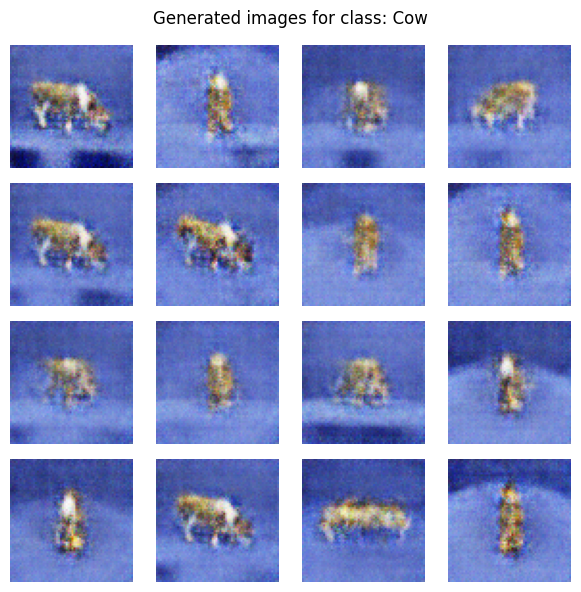

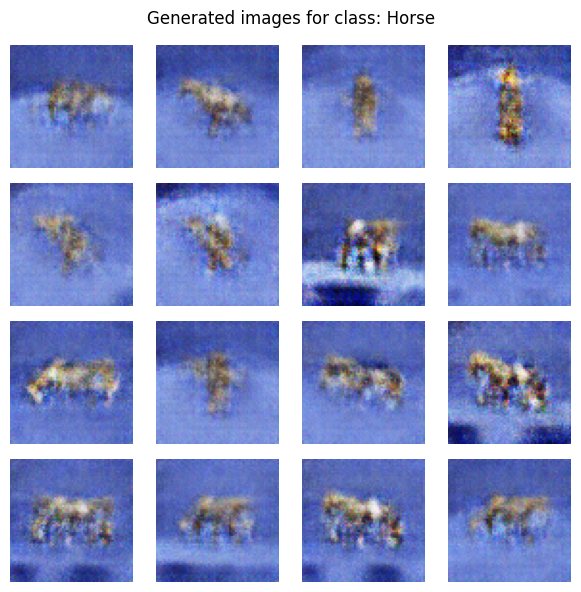

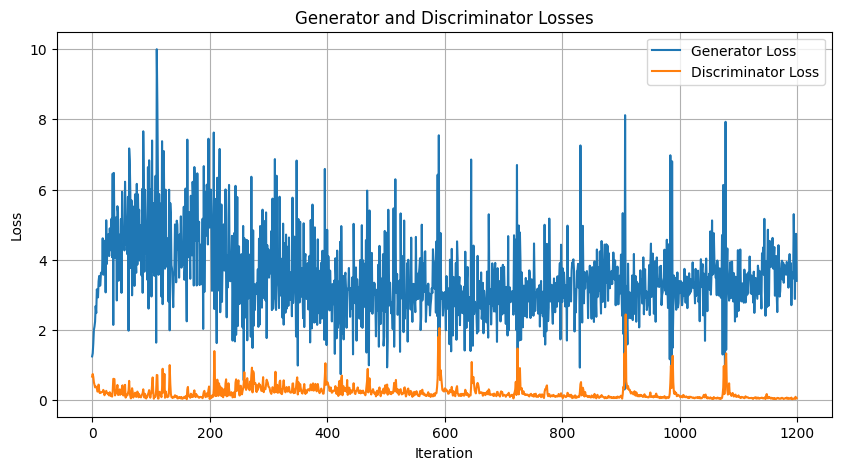

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ----------------------------
# Data Preparation
# ----------------------------
data_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = datasets.ImageFolder(root='dataset/Train', transform=data_transforms)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
n_classes = len(train_dataset.classes)

# ----------------------------
# Generator Network
# ----------------------------
class Generator(nn.Module):
    def __init__(self, latent_dim, n_classes, channels):
        super(Generator, self).__init__()
        self.label_emb = nn.Embedding(n_classes, n_classes)
        self.input_dim = latent_dim + n_classes

        self.main = nn.Sequential(
            nn.ConvTranspose2d(self.input_dim, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, channels, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, noise, labels):
        label_embedding = self.label_emb(labels).unsqueeze(2).unsqueeze(3)
        input = torch.cat((noise, label_embedding), dim=1)
        return self.main(input)

# ----------------------------
# Discriminator Network
# ----------------------------
class Discriminator(nn.Module):
    def __init__(self, n_classes, channels):
        super(Discriminator, self).__init__()
        self.label_emb = nn.Embedding(n_classes, n_classes)

        self.main = nn.Sequential(
            nn.Conv2d(channels + n_classes, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, img, labels):
        label_embedding = self.label_emb(labels).unsqueeze(2).unsqueeze(3)
        label_embedding = label_embedding.expand(-1, -1, img.size(2), img.size(3))
        d_in = torch.cat((img, label_embedding), dim=1)
        return self.main(d_in).view(-1, 1).squeeze(1)

# ----------------------------
# Training Setup
# ----------------------------
latent_dim = 20
channels = 3

generator = Generator(latent_dim, n_classes, channels).to(device)
discriminator = Discriminator(n_classes, channels).to(device)

criterion = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0001, betas=(0.5, 0.999))

num_epochs = 400
G_losses = []
D_losses = []

# ----------------------------
# Training Loop
# ----------------------------
for epoch in range(num_epochs):
    for i, (real_images, labels) in enumerate(train_loader):
        batch_size = real_images.size(0)
        real_images = real_images.to(device)
        labels = labels.to(device)

        valid = torch.ones(batch_size, device=device)
        fake = torch.zeros(batch_size, device=device)

        # ---------------------
        #  Train Discriminator
        # ---------------------
        optimizer_D.zero_grad()

        z = torch.randn(batch_size, latent_dim, 1, 1, device=device)
        gen_labels = torch.randint(0, n_classes, (batch_size,), device=device)
        fake_images = generator(z, gen_labels).detach()

        real_loss = criterion(discriminator(real_images, labels), valid)
        fake_loss = criterion(discriminator(fake_images, gen_labels), fake)
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()

        # -----------------
        #  Train Generator
        # -----------------
        optimizer_G.zero_grad()

        z = torch.randn(batch_size, latent_dim, 1, 1, device=device)
        gen_labels = torch.randint(0, n_classes, (batch_size,), device=device)
        fake_images = generator(z, gen_labels)
        g_loss = criterion(discriminator(fake_images, gen_labels), valid)

        g_loss.backward()
        optimizer_G.step()

        G_losses.append(g_loss.item())
        D_losses.append(d_loss.item())

        if i % 100 == 0:
            print(f"[Epoch {epoch}/{num_epochs}] [Batch {i}/{len(train_loader)}] [D loss: {d_loss.item():.4f}] [G loss: {g_loss.item():.4f}]")

print("Training complete.")

# ----------------------------
# Generate Images by Class
# ----------------------------
with torch.no_grad():
    for label_index, class_name in enumerate(train_dataset.classes):
        z = torch.randn(16, latent_dim, 1, 1, device=device)
        label_tensor = torch.full((16,), label_index, dtype=torch.long, device=device)
        fake_images = generator(z, label_tensor).detach().cpu()

        fig, axes = plt.subplots(4, 4, figsize=(6, 6))
        for i, ax in enumerate(axes.flatten()):
            img = fake_images[i].numpy().transpose(1, 2, 0)
            img = (img * 0.5) + 0.5
            ax.imshow(img)
            ax.axis('off')
        plt.suptitle(f"Generated images for class: {class_name}")
        plt.tight_layout()
        plt.show()

# ----------------------------
# Plot Losses
# ----------------------------
plt.figure(figsize=(10, 5))
plt.plot(G_losses, label='Generator Loss')
plt.plot(D_losses, label='Discriminator Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Generator and Discriminator Losses')
plt.legend()
plt.grid(True)
plt.show()


In [17]:
import os
from torchvision.utils import save_image

def save_images_by_class(generator, latent_dim, class_names, device, output_root, num_images=50):

    generator.eval()
    os.makedirs(output_root, exist_ok=True)

    with torch.no_grad():
        for class_index, class_name in enumerate(class_names):
            z = torch.randn(num_images, latent_dim, 1, 1, device=device)
            labels = torch.full((num_images,), class_index, dtype=torch.long, device=device)
            fake_images = generator(z, labels)

            class_dir = os.path.join(output_root, class_name)
            os.makedirs(class_dir, exist_ok=True)

            for i in range(num_images):
                img_path = os.path.join(class_dir, f"{class_name}_{i+1:03d}.png")
                save_image(fake_images[i], img_path, normalize=True)
            print(f"Saved {num_images} images to: {class_dir}")


In [18]:
save_images_by_class(generator, latent_dim, train_dataset.classes, device, f'generated_images/Tanh-20-latent-dim', num_images=50)

Saved 50 images to: generated_images/Tanh-20-latent-dim/Cow
Saved 50 images to: generated_images/Tanh-20-latent-dim/Horse


[Epoch 0/400] [Batch 0/3] [D loss: 0.6908] [G loss: 1.6574]
[Epoch 1/400] [Batch 0/3] [D loss: 0.1218] [G loss: 4.3641]
[Epoch 2/400] [Batch 0/3] [D loss: 0.0764] [G loss: 5.4230]
[Epoch 3/400] [Batch 0/3] [D loss: 0.0596] [G loss: 5.6484]
[Epoch 4/400] [Batch 0/3] [D loss: 0.0436] [G loss: 5.4022]
[Epoch 5/400] [Batch 0/3] [D loss: 0.0397] [G loss: 6.3791]
[Epoch 6/400] [Batch 0/3] [D loss: 0.0264] [G loss: 6.9006]
[Epoch 7/400] [Batch 0/3] [D loss: 0.0191] [G loss: 7.0794]
[Epoch 8/400] [Batch 0/3] [D loss: 0.0192] [G loss: 6.9335]
[Epoch 9/400] [Batch 0/3] [D loss: 0.0275] [G loss: 5.9020]
[Epoch 10/400] [Batch 0/3] [D loss: 0.0495] [G loss: 9.9227]
[Epoch 11/400] [Batch 0/3] [D loss: 1.4124] [G loss: 11.6841]
[Epoch 12/400] [Batch 0/3] [D loss: 0.0273] [G loss: 12.1607]
[Epoch 13/400] [Batch 0/3] [D loss: 0.9336] [G loss: 11.8469]
[Epoch 14/400] [Batch 0/3] [D loss: 0.0079] [G loss: 7.9077]
[Epoch 15/400] [Batch 0/3] [D loss: 0.0677] [G loss: 8.0921]
[Epoch 16/400] [Batch 0/3] [D l

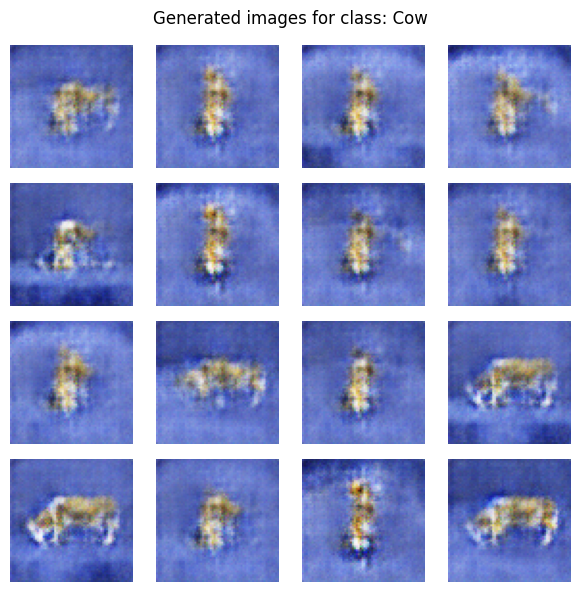

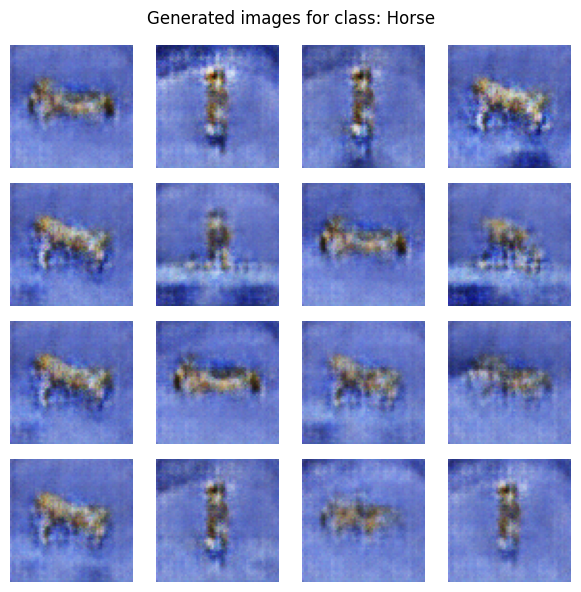

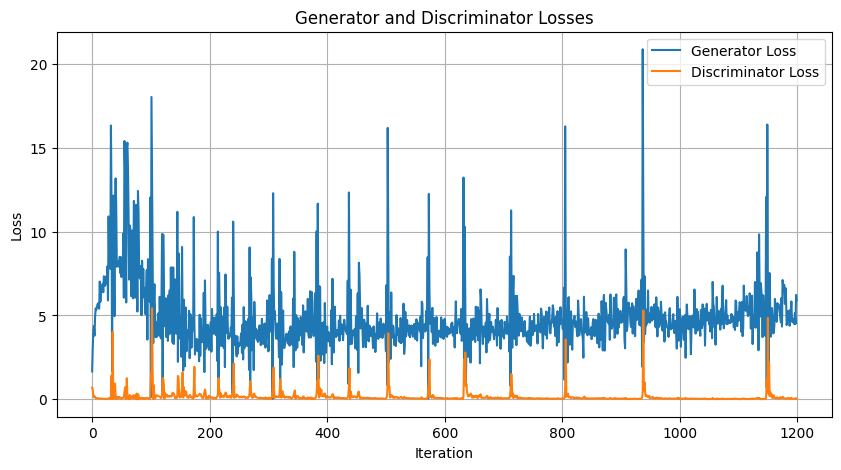

In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ----------------------------
# Data Preparation
# ----------------------------
data_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = datasets.ImageFolder(root='dataset/Train', transform=data_transforms)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
n_classes = len(train_dataset.classes)

# ----------------------------
# Generator Network
# ----------------------------
class Generator(nn.Module):
    def __init__(self, latent_dim, n_classes, channels):
        super(Generator, self).__init__()
        self.label_emb = nn.Embedding(n_classes, n_classes)
        self.input_dim = latent_dim + n_classes

        self.main = nn.Sequential(
            nn.ConvTranspose2d(self.input_dim, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, channels, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, noise, labels):
        label_embedding = self.label_emb(labels).unsqueeze(2).unsqueeze(3)
        input = torch.cat((noise, label_embedding), dim=1)
        return self.main(input)

# ----------------------------
# Discriminator Network
# ----------------------------
class Discriminator(nn.Module):
    def __init__(self, n_classes, channels):
        super(Discriminator, self).__init__()
        self.label_emb = nn.Embedding(n_classes, n_classes)

        self.main = nn.Sequential(
            nn.Conv2d(channels + n_classes, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, img, labels):
        label_embedding = self.label_emb(labels).unsqueeze(2).unsqueeze(3)
        label_embedding = label_embedding.expand(-1, -1, img.size(2), img.size(3))
        d_in = torch.cat((img, label_embedding), dim=1)
        return self.main(d_in).view(-1, 1).squeeze(1)

# ----------------------------
# Training Setup
# ----------------------------
latent_dim = 30
channels = 3

generator = Generator(latent_dim, n_classes, channels).to(device)
discriminator = Discriminator(n_classes, channels).to(device)

criterion = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

num_epochs = 400
G_losses = []
D_losses = []

# ----------------------------
# Training Loop
# ----------------------------
for epoch in range(num_epochs):
    for i, (real_images, labels) in enumerate(train_loader):
        batch_size = real_images.size(0)
        real_images = real_images.to(device)
        labels = labels.to(device)

        valid = torch.ones(batch_size, device=device)
        fake = torch.zeros(batch_size, device=device)

        # ---------------------
        #  Train Discriminator
        # ---------------------
        optimizer_D.zero_grad()

        z = torch.randn(batch_size, latent_dim, 1, 1, device=device)
        gen_labels = torch.randint(0, n_classes, (batch_size,), device=device)
        fake_images = generator(z, gen_labels).detach()

        real_loss = criterion(discriminator(real_images, labels), valid)
        fake_loss = criterion(discriminator(fake_images, gen_labels), fake)
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()

        # -----------------
        #  Train Generator
        # -----------------
        optimizer_G.zero_grad()

        z = torch.randn(batch_size, latent_dim, 1, 1, device=device)
        gen_labels = torch.randint(0, n_classes, (batch_size,), device=device)
        fake_images = generator(z, gen_labels)
        g_loss = criterion(discriminator(fake_images, gen_labels), valid)

        g_loss.backward()
        optimizer_G.step()

        G_losses.append(g_loss.item())
        D_losses.append(d_loss.item())

        if i % 100 == 0:
            print(f"[Epoch {epoch}/{num_epochs}] [Batch {i}/{len(train_loader)}] [D loss: {d_loss.item():.4f}] [G loss: {g_loss.item():.4f}]")

print("Training complete.")

# ----------------------------
# Generate Images by Class
# ----------------------------
with torch.no_grad():
    for label_index, class_name in enumerate(train_dataset.classes):
        z = torch.randn(16, latent_dim, 1, 1, device=device)
        label_tensor = torch.full((16,), label_index, dtype=torch.long, device=device)
        fake_images = generator(z, label_tensor).detach().cpu()

        fig, axes = plt.subplots(4, 4, figsize=(6, 6))
        for i, ax in enumerate(axes.flatten()):
            img = fake_images[i].numpy().transpose(1, 2, 0)
            img = (img * 0.5) + 0.5
            ax.imshow(img)
            ax.axis('off')
        plt.suptitle(f"Generated images for class: {class_name}")
        plt.tight_layout()
        plt.show()

# ----------------------------
# Plot Losses
# ----------------------------
plt.figure(figsize=(10, 5))
plt.plot(G_losses, label='Generator Loss')
plt.plot(D_losses, label='Discriminator Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Generator and Discriminator Losses')
plt.legend()
plt.grid(True)
plt.show()


In [20]:
save_images_by_class(generator, latent_dim, train_dataset.classes, device, f'generated_images/Tanh-30-latent-dim', num_images=50)

Saved 50 images to: generated_images/Tanh-30-latent-dim/Cow
Saved 50 images to: generated_images/Tanh-30-latent-dim/Horse
